<a href="https://colab.research.google.com/github/ShakthivelNadar/Stock-Price-Prediction/blob/main/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import yfinance as yf

In [2]:
stock_symbol = "AAPL"   # You can change to any stock
start_date = "2015-01-01"
end_date = "2024-01-01"

df = yf.download(stock_symbol, start=start_date, end=end_date)
df = df[['Close']]
df.head()

/tmp/ipython-input-3815364555.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.237551
2015-01-05,23.554741
2015-01-06,23.556961
2015-01-07,23.887281
2015-01-08,24.805084


In [3]:
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

In [4]:
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df.dropna(inplace=True)
df.head()

Price,Close,MA_20,MA_50,RSI
Ticker,AAPL,,,
Date,,,,
2015-03-16,27.809700,28.424204,26.586998,32.710750
2015-03-17,28.274866,28.415413,26.667745,45.533471
2015-03-18,28.593134,28.412631,26.768513,44.971714
2015-03-19,28.377241,28.402059,26.864918,47.391319
2015-03-20,28.021133,28.361996,26.947595,41.765552


In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)

In [6]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Predict Close price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, 60)

In [7]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [8]:
model = Sequential()

model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(100))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,501 (478.52 KB)

 Trainable params: 122,501 (478.52 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    verbose=1)

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0221 - val_loss: 0.0017
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 8.5018e-04 - val_loss: 0.0026
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 6.8841e-04 - val_loss: 0.0040
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 6.8485e-04 - val_loss: 0.0011
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 6.7709e-04 - val_loss: 0.0023
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 7.6619e-04 - val_loss: 0.0011
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 5.8040e-04 - val_loss: 0.0012
Epoch 9/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 8.4623e-04 - val_loss: 8.9546e-04
Epoch 10/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 6.2050e-04 - val_loss: 8.3385e-04
Epoch 11/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 5.8852e-04 - val_loss: 0.0017
Epoch 12/25
49/49 ━

In [10]:
predicted_prices = model.predict(X_test)

predicted_prices = scaler.inverse_transform(
    np.concatenate((predicted_prices, np.zeros((predicted_prices.shape[0], scaled_data.shape[1]-1))), axis=1)
)[:,0]

actual_prices = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1,1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1)
)[:,0]

rmse = sqrt(mean_squared_error(actual_prices, predicted_prices))
rmse

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


6.337207738641349

In [11]:
test_dates = df.index[-len(actual_prices):]

backtest_df = pd.DataFrame({
    'Date': test_dates,
    'Actual Price': actual_prices,
    'Predicted Price': predicted_prices
})

backtest_df.head()

,Date,Actual Price,Predicted Price
0,2022-04-13,167.111496,163.626305
1,2022-04-14,162.100098,162.457446
2,2022-04-18,161.884384,161.063834
3,2022-04-19,164.169403,159.776155
4,2022-04-20,164.002670,158.747664


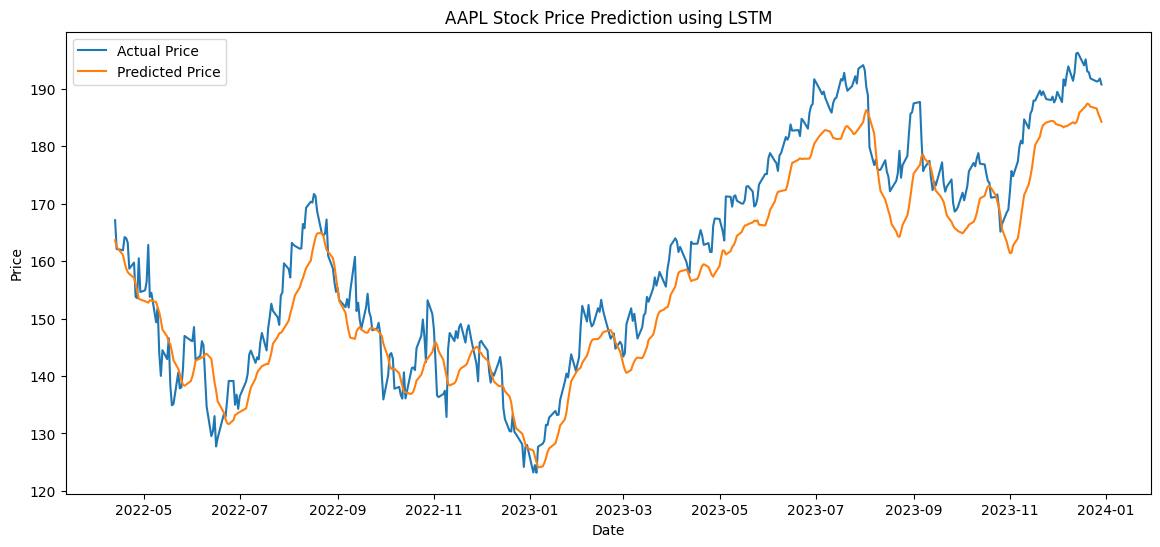

In [12]:
plt.figure(figsize=(14,6))
plt.plot(backtest_df['Date'], backtest_df['Actual Price'], label='Actual Price')
plt.plot(backtest_df['Date'], backtest_df['Predicted Price'], label='Predicted Price')
plt.title(f"{stock_symbol} Stock Price Prediction using LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()